# Purpose
* playing around with `numpyro.do` using the example from [Causal Inference 2: Illustrating Interventions via a Toy Example](https://www.inference.vc/causal-inference-2-illustrating-interventions-in-a-toy-example/)

## Notes and links
* [Interventions `pyro.do`](https://nbviewer.jupyter.org/github/altdeep/causalML/blob/master/tutorials/1-introduction/3_GMM_lecture.ipynb#Interventions)
* [Numpyro `do`](http://num.pyro.ai/en/latest/handlers.html?highlight=handlers.do#do)
* [causalML/tutorials/](https://github.com/altdeep/causalML/tree/master/tutorials)

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import arviz as az
import numpyro
import numpyro.distributions as dist
from numpyro.infer.util import Predictive
import pandas as pd
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p arviz,jax,matplotlib,numpy,pandas,scipy,numpyro

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

arviz     : 0.11.2
jax       : 0.2.19
matplotlib: 3.4.3
numpy     : 1.20.3
pandas    : 1.3.2
scipy     : 1.6.2
numpyro   : 0.7.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: aa5231eb37d37213751dcf9b64b44ae3058e56c4

Git branch: master



In [5]:
rng_key = jax.random.PRNGKey(2)
keys = jax.random.split(rng_key, 6)

num_warmup = 5000
num_samples = 100_000
num_chains = 1

In [6]:
def conditional_continous(
    dataf: pd.DataFrame, *, column_x: str, column_y: str, lower: float, upper: float
):
    return dataf[((dataf[column_x] >= lower) & (dataf[column_x] <= upper))][
        column_y
    ].values

## Define Models

In [7]:
def model_01():
    x = numpyro.sample("x", dist.Normal(0, 1))
    _y = numpyro.sample("_y", dist.Normal(0, 1))
    y = numpyro.deterministic("y", x + 1 + jnp.sqrt(3) * _y)
    return x, y


def model_02():
    _y = numpyro.sample("_y", dist.Normal(0, 1))
    _x = numpyro.sample("_x", dist.Normal(0, 1))
    y = numpyro.deterministic("y", 1 + 2 * _y)
    x = numpyro.deterministic("x", (y - 1) / 4 + jnp.sqrt(3) * _x / 2)
    return x, y


def model_03():
    _z = numpyro.sample("_z", dist.Normal(0, 1))
    _y = numpyro.sample("_y", dist.Normal(0, 1))
    y = numpyro.deterministic("y", _z + 1 + jnp.sqrt(3) * _y)
    x = numpyro.deterministic("x", _z)
    return x, y

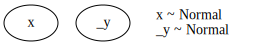

In [8]:
numpyro.render_model(model_01, (), render_distributions=True)

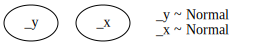

In [9]:
numpyro.render_model(model_02, (), render_distributions=True)

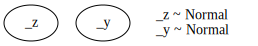

In [10]:
numpyro.render_model(model_03, (), render_distributions=True)

In [11]:
data_joint = {}
lower_ = 2.9
upper_ = 3.0
intervention = 3.0

## Model 01

In [12]:
kernel = NUTS(model_01)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[0])
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 105000/105000 [00:38<00:00, 2742.28it/s, 3 steps of size 9.76e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _y      0.00      1.00      0.00     -1.65      1.62 102491.14      1.00
         x     -0.00      1.00     -0.01     -1.67      1.64 104170.39      1.00
         y      1.00      2.00      1.01     -2.28      4.28 102543.25      1.00

Number of divergences: 0


In [13]:
ds_01 = az.from_numpyro(mcmc)

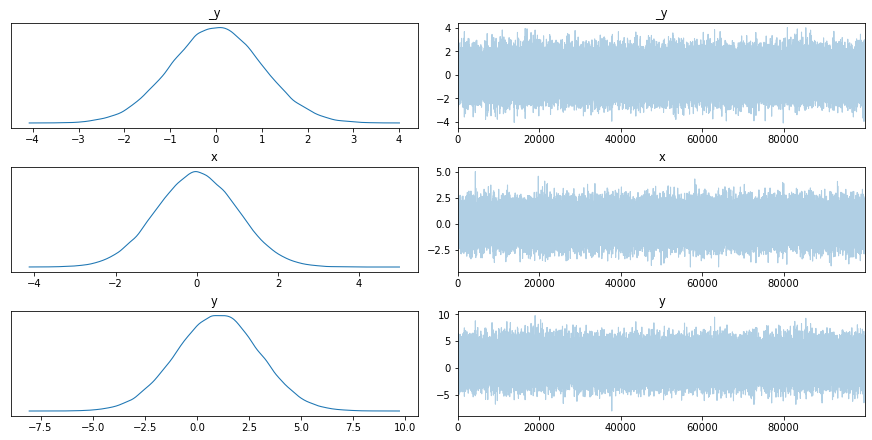

In [14]:
az.plot_trace(ds_01);

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='x', ylabel='y'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

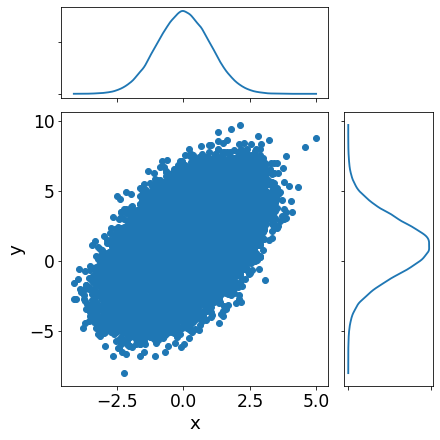

In [15]:
az.plot_joint(ds_01, var_names=["x", "y"], kind="scatter", figsize=(6, 6))

In [16]:
df_01 = pd.DataFrame(
    {
        "x": np.array(ds_01["posterior"]["x"][0, :]),
        "y": np.array(ds_01["posterior"]["y"][0, :]),
    }
)
data_joint["y_01"] = conditional_continous(df_01, column_x="x", column_y="y", lower=lower_, upper=upper_)

In [17]:
conditional_continous(df_01, column_x="x", column_y="y", lower=lower_, upper=upper_).shape

(58,)

<AxesSubplot:title={'center':'y'}>

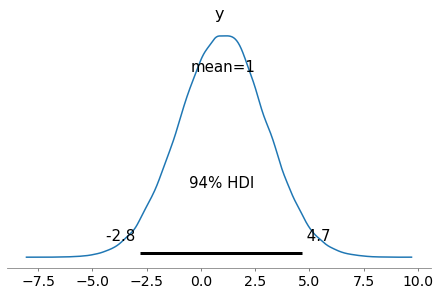

In [18]:
az.plot_posterior(ds_01, var_names="y")

## Model 02

In [19]:
kernel = NUTS(model_02)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[1])
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 105000/105000 [00:37<00:00, 2822.46it/s, 3 steps of size 8.77e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _x      0.00      1.00      0.01     -1.67      1.62 100481.52      1.00
        _y     -0.00      1.00     -0.00     -1.64      1.63  89178.90      1.00
         x      0.00      1.00      0.00     -1.63      1.65  98241.80      1.00
         y      1.00      1.99      0.99     -2.27      4.27  89178.90      1.00

Number of divergences: 0


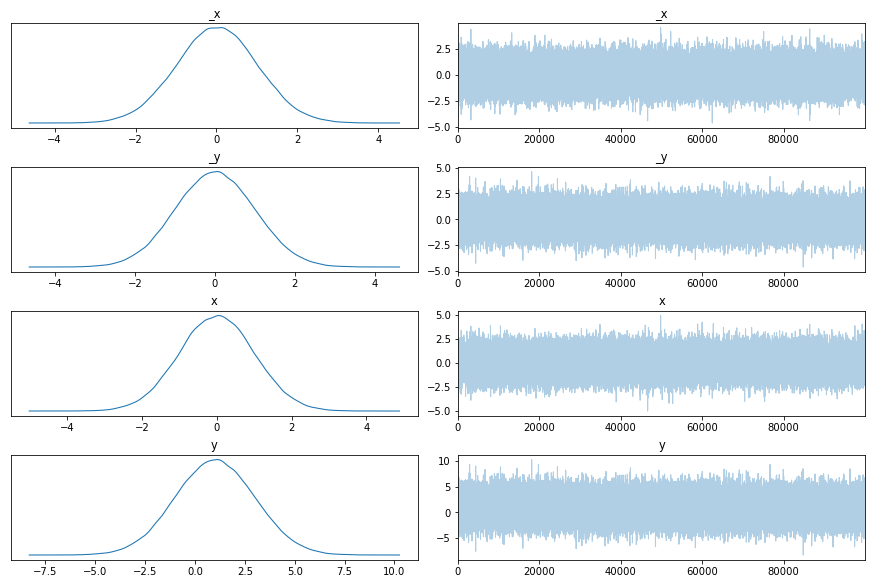

In [20]:
ds_02 = az.from_numpyro(mcmc)
az.plot_trace(ds_02);

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='x', ylabel='y'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

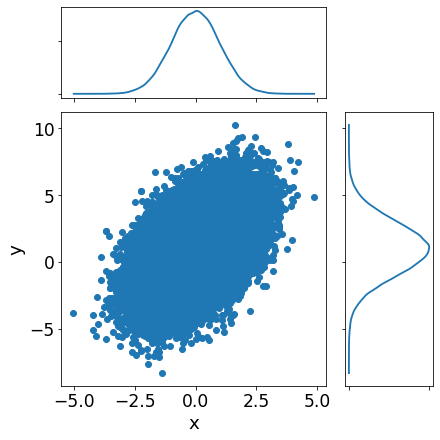

In [21]:
az.plot_joint(ds_02, var_names=["x", "y"], kind="scatter", figsize=(6, 6))

In [22]:
df_02 = pd.DataFrame(
    {
        "x": np.array(ds_02["posterior"]["x"][0, :]),
        "y": np.array(ds_02["posterior"]["y"][0, :]),
    }
)

data_joint["y_02"] = conditional_continous(df_02, column_x="x", column_y="y", lower=lower_, upper=upper_)

In [23]:
conditional_continous(df_02, column_x="x", column_y="y", lower=lower_, upper=upper_).shape

(46,)

<AxesSubplot:title={'center':'y'}>

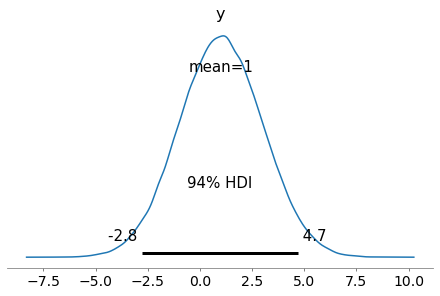

In [24]:
az.plot_posterior(ds_02, var_names="y")

## Model 03

In [25]:
kernel = NUTS(model_03)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[2])
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 105000/105000 [00:38<00:00, 2722.59it/s, 1 steps of size 9.24e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _y      0.00      0.99      0.00     -1.61      1.65  98740.21      1.00
        _z     -0.00      0.99     -0.00     -1.68      1.59  93147.25      1.00
         x     -0.00      0.99     -0.00     -1.68      1.59  93147.25      1.00
         y      1.00      1.98      1.01     -2.22      4.27  98981.78      1.00

Number of divergences: 0


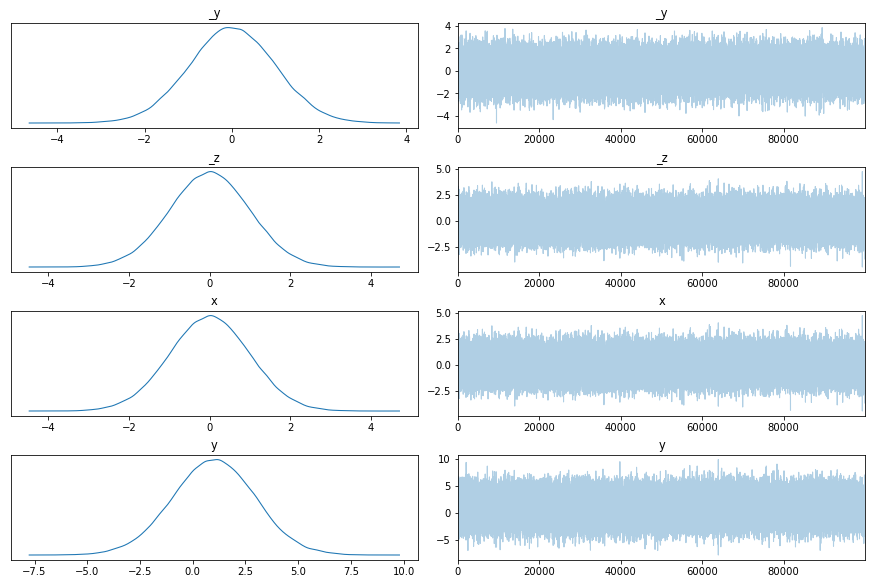

In [26]:
ds_03 = az.from_numpyro(mcmc)
az.plot_trace(ds_03);

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='x', ylabel='y'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

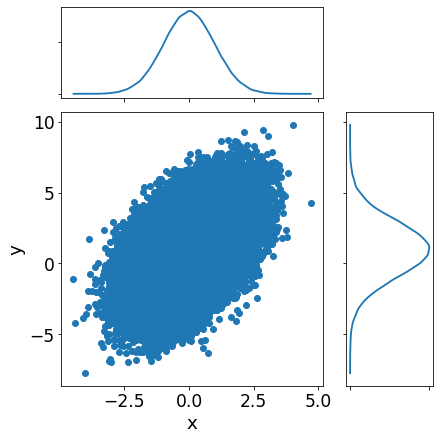

In [27]:
az.plot_joint(ds_03, var_names=["x", "y"], kind="scatter", figsize=(6, 6))

In [28]:
df_03 = pd.DataFrame(
    {
        "x": np.array(ds_03["posterior"]["x"][0, :]),
        "y": np.array(ds_03["posterior"]["y"][0, :]),
    }
)

data_joint["y_03"] = conditional_continous(df_03, column_x="x", column_y="y", lower=lower_, upper=upper_)

In [29]:
conditional_continous(df_03, column_x="x", column_y="y", lower=lower_, upper=upper_).shape

(40,)

<AxesSubplot:title={'center':'y'}>

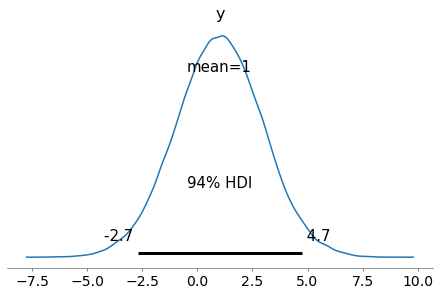

In [30]:
az.plot_posterior(ds_03, var_names="y")

## Conditional Distribution $P(Y | X = intervention)$

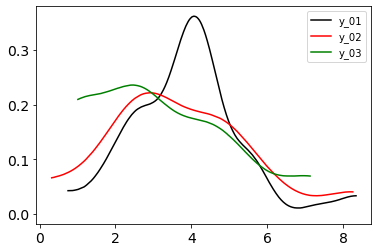

In [31]:
fig, ax = plt.subplots()
for k, c in zip(["y_01", "y_02", "y_03"], ["k", "r", "g"]):
    az.plot_dist(data_joint[k], ax=ax, label=k, color=c)

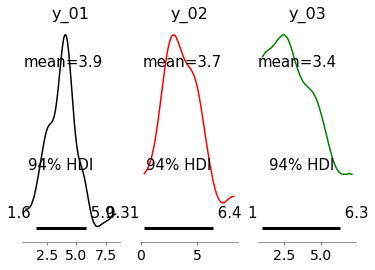

In [32]:
fig, ax = plt.subplots(1, 3)
for k, c, a in zip(["y_01", "y_02", "y_03"], ["k", "r", "g"], ax.flatten()):
    az.plot_posterior(data_joint, var_names=k, ax=a, color=c, skipna=True)

## Condition the models

In [33]:
intervention

3.0

In [34]:
data = {}
data["x"] = np.array([intervention] * (num_samples * num_chains))

In [35]:
conditioned_model_01 = numpyro.handlers.condition(model_01, {"x": intervention})
conditioned_model_02 = numpyro.handlers.condition(model_02, {"x": intervention})
conditioned_model_03 = numpyro.handlers.condition(model_03, {"x": intervention})

In [36]:
kernel = NUTS(conditioned_model_01)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[0])
mcmc.print_summary(exclude_deterministic=False)
data["y_01"] = np.array(mcmc.get_samples()["y"])
ds_cond_01 = az.from_numpyro(mcmc)

sample: 100%|██████████| 105000/105000 [00:31<00:00, 3284.80it/s, 3 steps of size 9.07e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _y      0.00      1.00      0.00     -1.64      1.64  41271.38      1.00
         y      4.00      1.73      4.00      1.15      6.84  41271.38      1.00

Number of divergences: 0


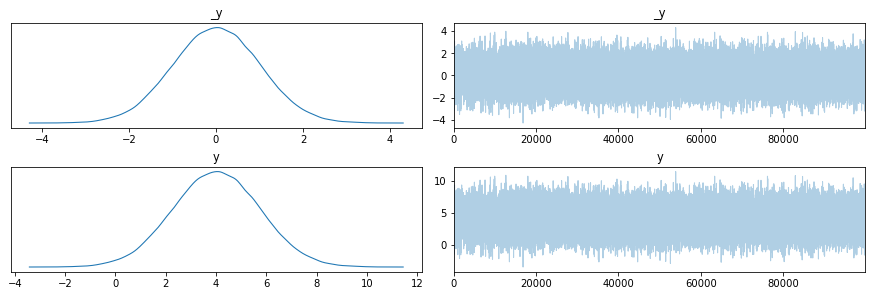

In [37]:
az.plot_trace(ds_cond_01);

In [38]:
kernel = NUTS(conditioned_model_02)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[0])
mcmc.print_summary(exclude_deterministic=False)
data["y_02"] = np.array(mcmc.get_samples()["y"])
ds_cond_02 = az.from_numpyro(mcmc)

sample: 100%|██████████| 105000/105000 [00:40<00:00, 2607.59it/s, 3 steps of size 9.76e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _x      0.00      1.00      0.00     -1.65      1.62 102491.14      1.00
        _y     -0.00      1.00     -0.01     -1.67      1.64 104170.39      1.00
         x      0.00      1.00      0.00     -1.64      1.64 102543.25      1.00
         y      0.99      2.01      0.99     -2.33      4.28 104170.39      1.00

Number of divergences: 0


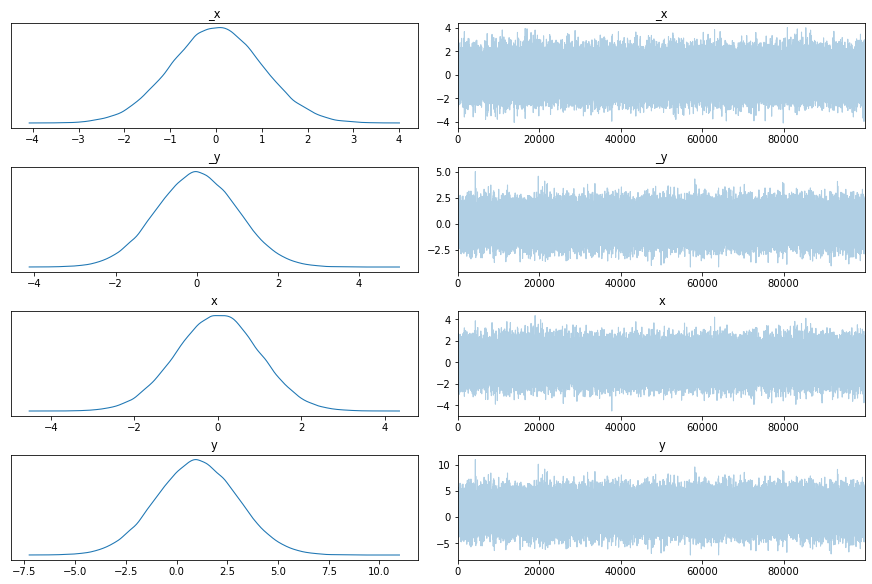

In [39]:
az.plot_trace(ds_cond_02);

In [40]:
kernel = NUTS(conditioned_model_03)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[0])
mcmc.print_summary(exclude_deterministic=False)
data["y_03"] = np.array(mcmc.get_samples()["y"])
ds_cond_03 = az.from_numpyro(mcmc)

sample: 100%|██████████| 105000/105000 [00:38<00:00, 2694.79it/s, 3 steps of size 9.76e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _y      0.00      1.00      0.00     -1.65      1.62 102491.14      1.00
        _z     -0.00      1.00     -0.01     -1.67      1.64 104170.39      1.00
         x     -0.00      1.00     -0.01     -1.67      1.64 104170.39      1.00
         y      1.00      2.00      1.01     -2.28      4.28 102543.25      1.00

Number of divergences: 0


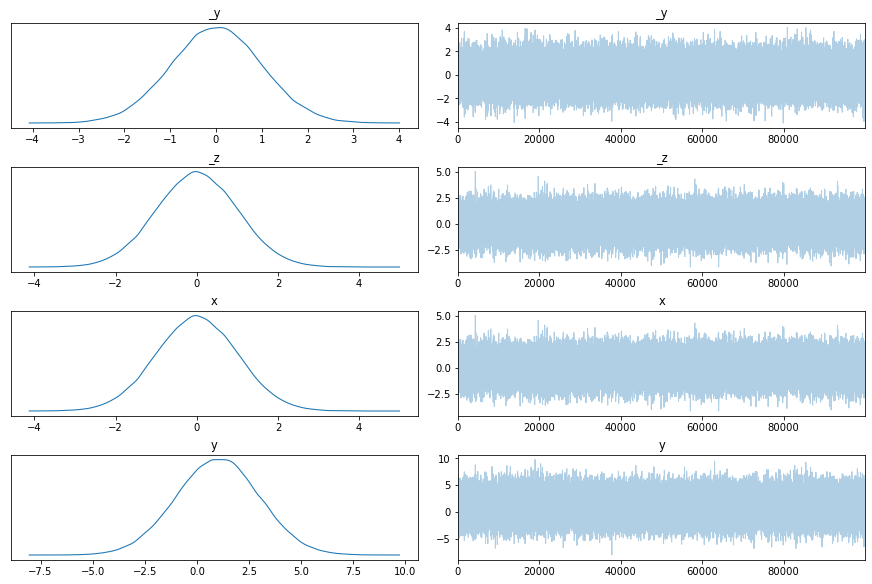

In [41]:
az.plot_trace(ds_cond_03);

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5


(15.0, -15.0)

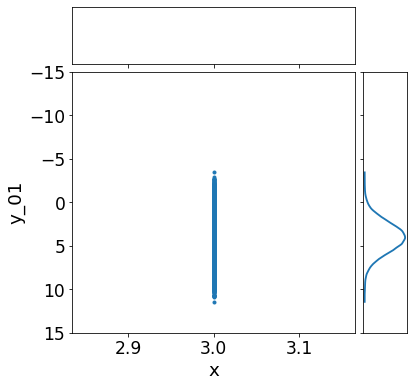

In [42]:
az.plot_pair(
    data, var_names=["x", "y_01"], kind="scatter", figsize=(6, 6), marginals=True
)
plt.ylim([15, -15])

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5


(15.0, -15.0)

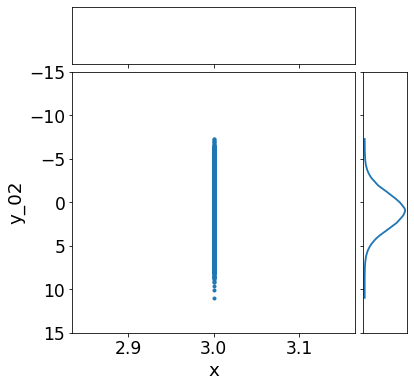

In [43]:
az.plot_pair(
    data, var_names=["x", "y_02"], kind="scatter", figsize=(6, 6), marginals=True
)
plt.ylim([15, -15])

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='x', ylabel='y'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

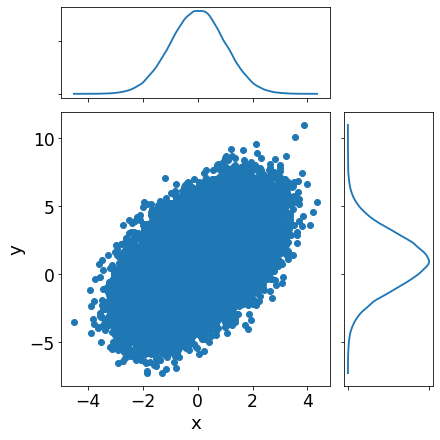

In [44]:
az.plot_joint(ds_cond_02, var_names=["x", "y"], kind="scatter", figsize=(6, 6))

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5


(15.0, -15.0)

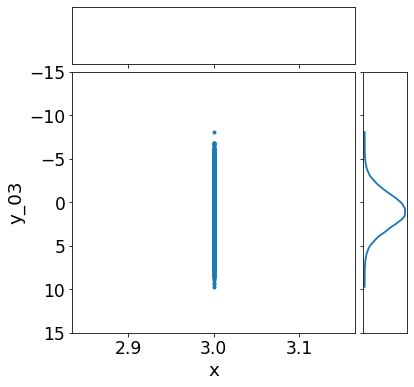

In [45]:
az.plot_pair(
    data, var_names=["x", "y_03"], kind="scatter", figsize=(6, 6), marginals=True
)
plt.ylim([15, -15])

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='x', ylabel='y'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

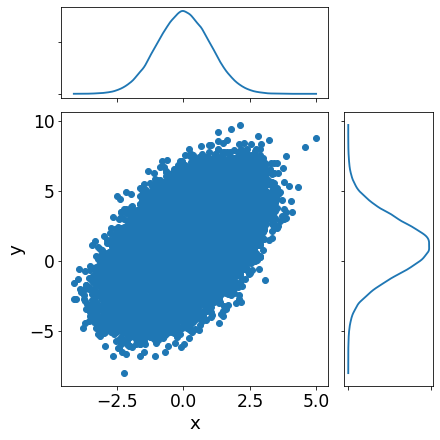

In [46]:
az.plot_joint(ds_cond_03, var_names=["x", "y"], kind="scatter", figsize=(6, 6))

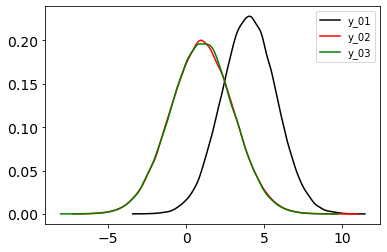

In [47]:
fig, ax = plt.subplots()
for k, c in zip(["y_01", "y_02", "y_03"], ["k", "r", "g"]):
    az.plot_dist(data[k], ax=ax, label=k, color=c)

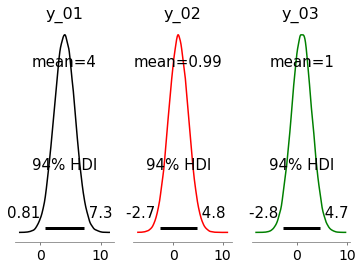

In [48]:
fig, ax = plt.subplots(1, 3)
for k, c, a in zip(["y_01", "y_02", "y_03"], ["k", "r", "g"], ax.flatten()):
    az.plot_posterior(data, var_names=k, ax=a, color=c, skipna=False)

# do-operator
## Model 01 do

In [49]:
data_do = {}

In [50]:
model_01_do = numpyro.handlers.do(model_01, data={"x": intervention})

In [51]:
with numpyro.handlers.seed(rng_seed=0):
    for _ in range(10):
        print(model_01_do())

(3.0, DeviceArray(2.9838912, dtype=float32))
(3.0, DeviceArray(4.376099, dtype=float32))
(3.0, DeviceArray(6.3204794, dtype=float32))
(3.0, DeviceArray(2.6935291, dtype=float32))
(3.0, DeviceArray(-0.07042027, dtype=float32))
(3.0, DeviceArray(6.8289437, dtype=float32))
(3.0, DeviceArray(-0.36342144, dtype=float32))
(3.0, DeviceArray(4.5881953, dtype=float32))
(3.0, DeviceArray(6.7245765, dtype=float32))
(3.0, DeviceArray(3.786873, dtype=float32))


In [52]:
kernel = NUTS(model_01_do)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[2])
mcmc.print_summary(exclude_deterministic=False)
data_do["y_01"] = np.array(mcmc.get_samples()["y"])

sample: 100%|██████████| 105000/105000 [00:40<00:00, 2613.44it/s, 1 steps of size 9.24e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _y      0.00      0.99      0.00     -1.61      1.65  98740.21      1.00
         x     -0.00      0.99     -0.00     -1.68      1.59  93147.25      1.00
         y      4.00      1.72      4.00      1.21      6.86  98740.21      1.00

Number of divergences: 0


In [53]:
ds_01_do = az.from_numpyro(mcmc)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='x', ylabel='y'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

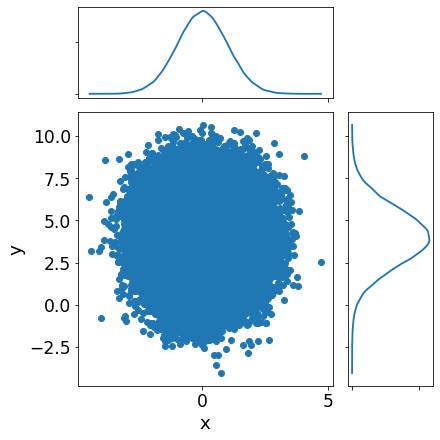

In [54]:
az.plot_joint(ds_01_do, var_names=["x", "y"], kind="scatter", figsize=(6, 6))

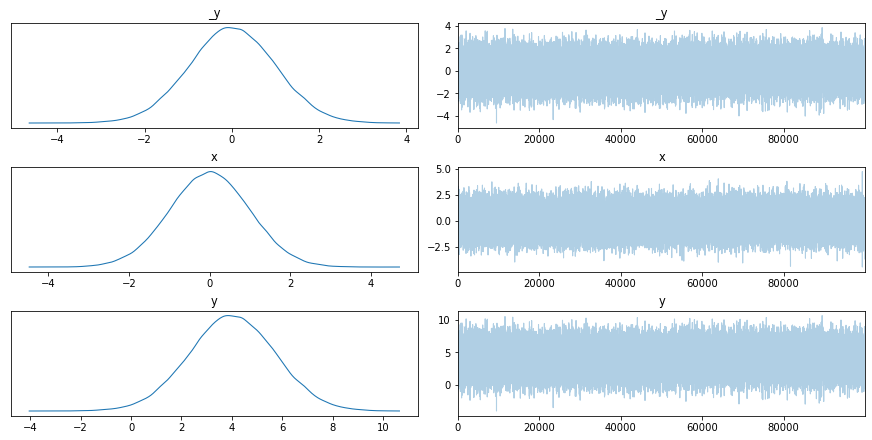

In [55]:
az.plot_trace(ds_01_do);

## Model 02 do

In [56]:
model_02_do = numpyro.handlers.do(model_02, data={"x": intervention})

kernel = NUTS(model_02_do)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[2])
mcmc.print_summary(exclude_deterministic=False)
data_do["y_02"] = np.array(mcmc.get_samples()["y"])

sample: 100%|██████████| 105000/105000 [00:39<00:00, 2632.57it/s, 1 steps of size 9.24e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _x      0.00      0.99      0.00     -1.61      1.65  98740.21      1.00
        _y     -0.00      0.99     -0.00     -1.68      1.59  93147.25      1.00
         x     -0.00      0.99      0.00     -1.61      1.64  98981.78      1.00
         y      0.99      1.99      1.00     -2.37      4.18  93147.25      1.00

Number of divergences: 0


In [57]:
ds_02_do = az.from_numpyro(mcmc)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='x', ylabel='y'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

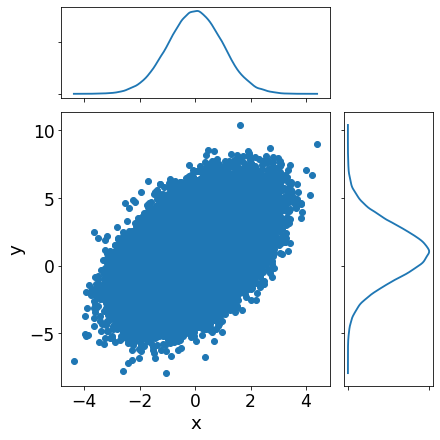

In [58]:
az.plot_joint(ds_02_do, var_names=["x", "y"], kind="scatter", figsize=(6, 6))

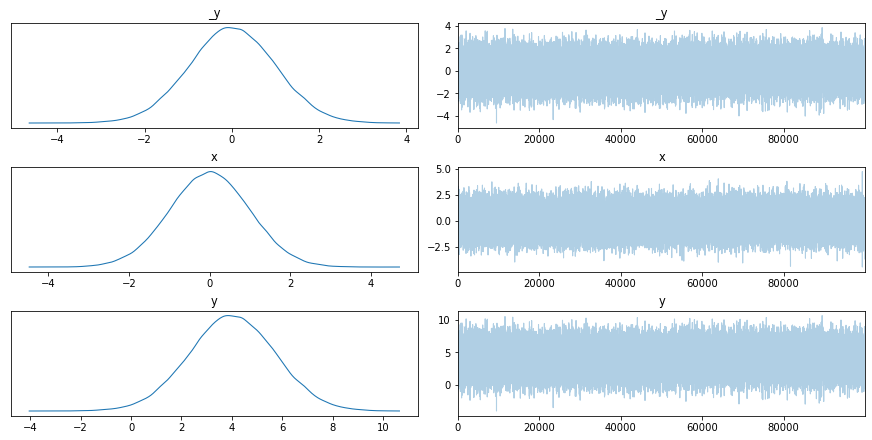

In [59]:
az.plot_trace(ds_01_do);

## Model 03 do

In [60]:
model_03_do = numpyro.handlers.do(model_03, data={"x": intervention})

kernel = NUTS(model_03_do)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[2])
mcmc.print_summary(exclude_deterministic=False)
data_do["y_03"] = np.array(mcmc.get_samples()["y"])

sample: 100%|██████████| 105000/105000 [00:37<00:00, 2777.64it/s, 1 steps of size 9.24e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _y      0.00      0.99      0.00     -1.61      1.65  98740.21      1.00
        _z     -0.00      0.99     -0.00     -1.68      1.59  93147.25      1.00
         x     -0.00      0.99     -0.00     -1.68      1.59  93147.25      1.00
         y      1.00      1.98      1.01     -2.22      4.27  98981.78      1.00

Number of divergences: 0


In [61]:
ds_03_do = az.from_numpyro(mcmc)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='x', ylabel='y'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

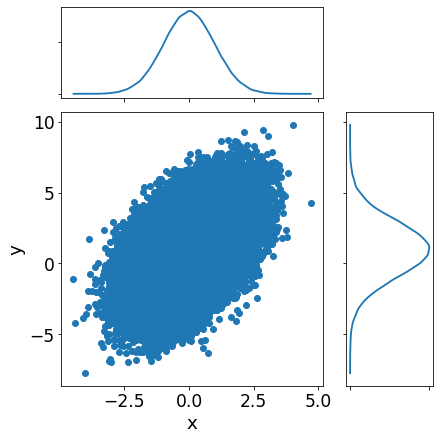

In [62]:
az.plot_joint(ds_03_do, var_names=["x", "y"], kind="scatter", figsize=(6, 6))

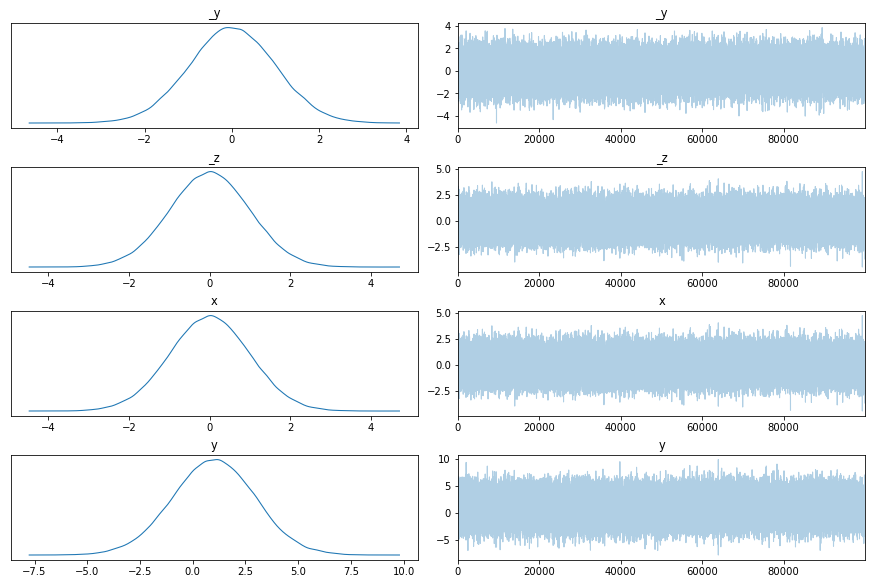

In [63]:
az.plot_trace(ds_03_do);

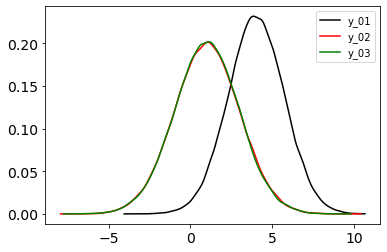

In [64]:
fig, ax = plt.subplots()
for k, c in zip(["y_01", "y_02", "y_03"], ["k", "r", "g"]):
    az.plot_dist(data_do[k], ax=ax, label=k, color=c)

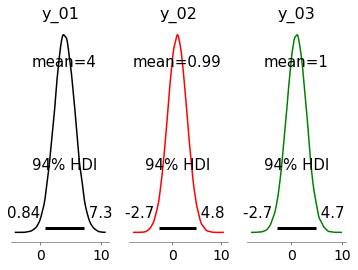

In [65]:
fig, ax = plt.subplots(1, 3)
for k, c, a in zip(["y_01", "y_02", "y_03"], ["k", "r", "g"], ax.flatten()):
    az.plot_posterior(data_do, var_names=k, ax=a, color=c, skipna=False)

## Example from Lectures on Causality: Jonas Peters, Part 1
* [Lecture video](https://youtu.be/zvrcyqcN9Wo?t=2283)

In [66]:
def model():
    x = numpyro.sample("x", dist.Normal())
    _y = numpyro.sample("_y", dist.Normal())
    y = numpyro.deterministic("y", -6 * x + _y)

In [67]:
kernel = NUTS(model)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[0])
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 105000/105000 [00:37<00:00, 2810.28it/s, 3 steps of size 9.76e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _y      0.00      1.00      0.00     -1.65      1.62 102491.14      1.00
         x     -0.00      1.00     -0.01     -1.67      1.64 104170.39      1.00
         y      0.03      6.10      0.05    -10.08      9.97 104318.16      1.00

Number of divergences: 0


In [68]:
ds_ = az.from_numpyro(mcmc)

<AxesSubplot:title={'center':'x'}>

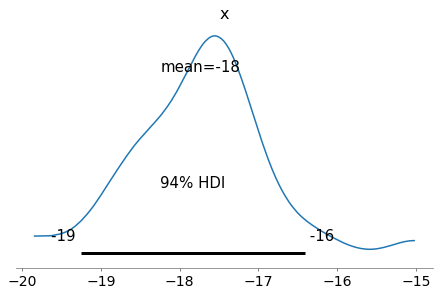

In [69]:
df_ = pd.DataFrame(
    {
        "x": np.array(ds_["posterior"]["x"][0, :]),
        "y": np.array(ds_["posterior"]["y"][0, :]),
    }
)

conditional_continous(df_, column_x="x", column_y="y", lower=2.9, upper=3.)
az.plot_posterior(conditional_continous(df_, column_x="x", column_y="y", lower=2.9, upper=3.))

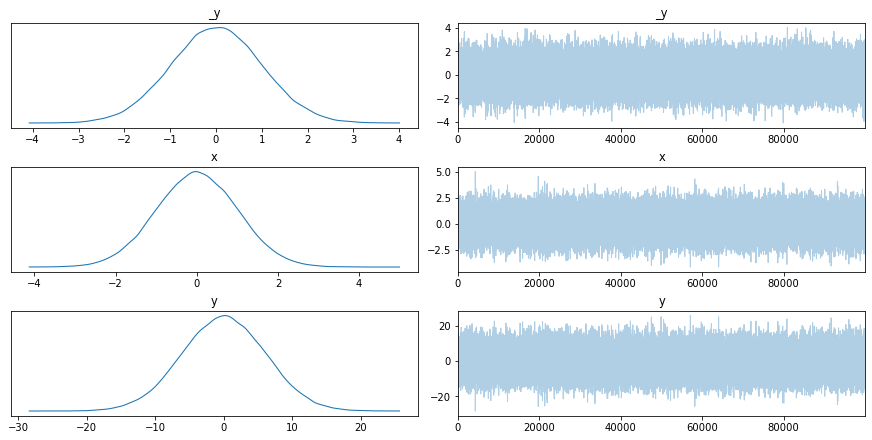

In [70]:
az.plot_trace(ds_);

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='x', ylabel='y'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

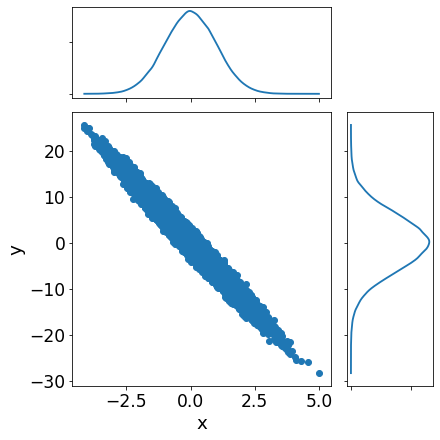

In [71]:
az.plot_joint(ds_, var_names=["x", "y"], kind="scatter", figsize=(6, 6))

In [72]:
model_do = numpyro.handlers.do(model, data={"x": 3.})

kernel = NUTS(model_do)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[2])
mcmc.print_summary(exclude_deterministic=False)
ds_d0 = az.from_numpyro(mcmc)

sample: 100%|██████████| 105000/105000 [00:39<00:00, 2649.87it/s, 1 steps of size 9.24e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _y      0.00      0.99      0.00     -1.61      1.65  98740.21      1.00
         x     -0.00      0.99     -0.00     -1.68      1.59  93147.25      1.00
         y    -18.00      0.99    -18.00    -19.61    -16.35  98740.21      1.00

Number of divergences: 0


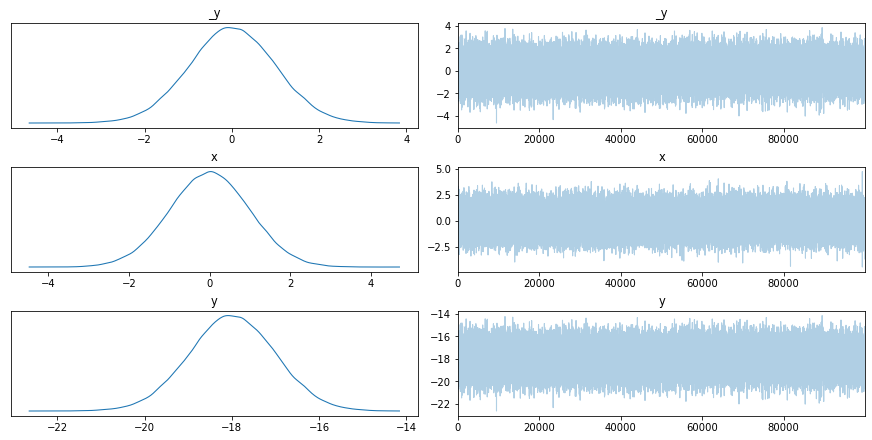

In [73]:
az.plot_trace(ds_d0);

<AxesSubplot:title={'center':'y'}>

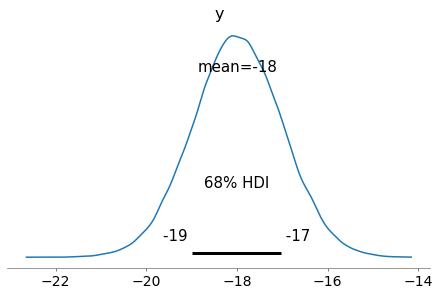

In [74]:
az.plot_posterior(ds_d0["posterior"], var_names="y", hdi_prob=0.68)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='x', ylabel='y'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

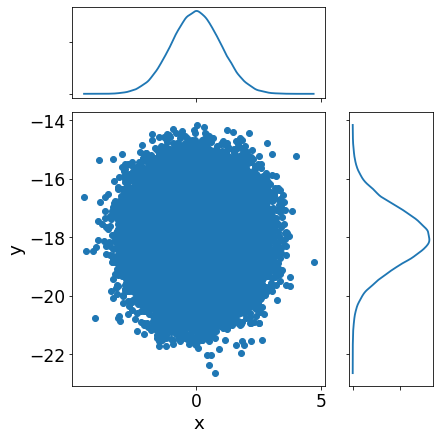

In [75]:
az.plot_joint(ds_d0, var_names=["x", "y"], kind="scatter", figsize=(6, 6))

In [76]:
conditioned_model = numpyro.handlers.condition(model, {"x": 3.0})
kernel = NUTS(conditioned_model)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[0])
mcmc.print_summary(exclude_deterministic=False)
ds_cond = az.from_numpyro(mcmc)

sample: 100%|██████████| 105000/105000 [00:33<00:00, 3108.17it/s, 3 steps of size 9.07e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _y      0.00      1.00      0.00     -1.64      1.64  41271.38      1.00
         y    -18.00      1.00    -18.00    -19.64    -16.36  41271.38      1.00

Number of divergences: 0


<AxesSubplot:title={'center':'y'}>

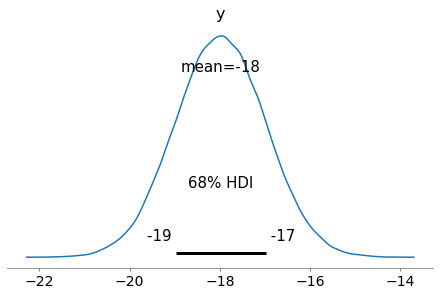

In [77]:
az.plot_posterior(ds_cond["posterior"], var_names="y", hdi_prob=0.68)

In [78]:
model_do = numpyro.handlers.do(model, data={"y": dist.Normal(2,2).sample(jax.random.PRNGKey(0), (100,))})

In [79]:
kernel = NUTS(model_do)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[2])
mcmc.print_summary(exclude_deterministic=False)
ds_d0 = az.from_numpyro(mcmc)

sample: 100%|██████████| 105000/105000 [00:37<00:00, 2784.40it/s, 1 steps of size 9.24e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _y      0.00      0.99      0.00     -1.61      1.65  98740.21      1.00
         x     -0.00      0.99     -0.00     -1.68      1.59  93147.25      1.00
         y      0.03      6.05      0.01    -10.04      9.86  93087.21      1.00

Number of divergences: 0


<AxesSubplot:title={'center':'y'}>

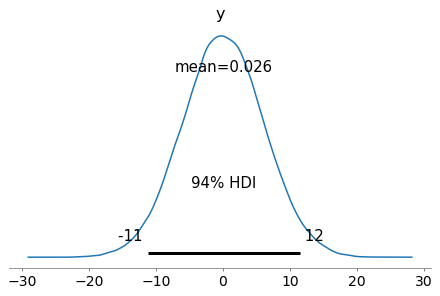

In [80]:
az.plot_posterior(ds_d0, var_names="y")

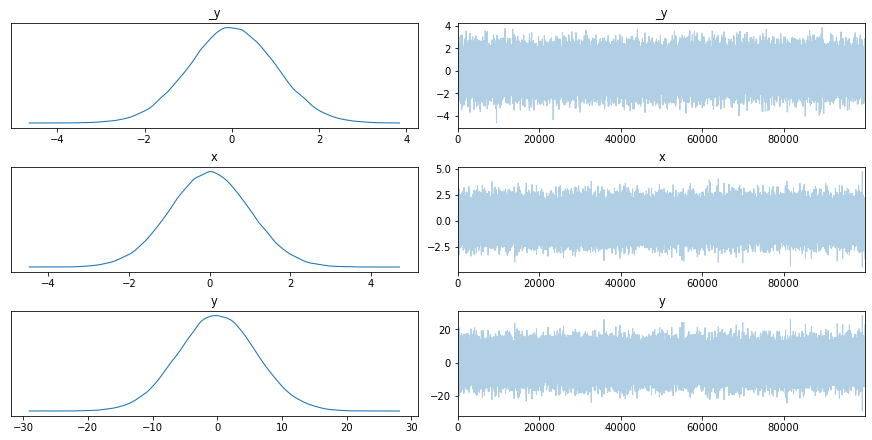

In [81]:
az.plot_trace(ds_d0);

## Numpyro do example
* [Source](https://num.pyro.ai/en/latest/handlers.html?highlight=handlers.do#do)
* Helpful post [Posterior Predictive of Interventional Distributions (do operator)](https://forum.pyro.ai/t/posterior-predictive-of-interventional-distributions-do-operator/1738/6?u=bdatko)

In [82]:
def model(x):
    s = numpyro.sample("s", dist.LogNormal())
    z = numpyro.sample("z", dist.Normal(x, s))
    return z ** 2

In [83]:
intervened_model = numpyro.handlers.do(model, data={"z": 16.})

In [84]:
with numpyro.handlers.trace() as exec_trace:
    z_square = numpyro.handlers.seed(intervened_model, 0)(1)

In [85]:
z_square, exec_trace

(256.0,
 OrderedDict([('s',
               {'type': 'sample',
                'name': 's',
                'fn': <numpyro.distributions.continuous.LogNormal at 0x7faed2f78460>,
                'args': (),
                'kwargs': {'rng_key': array([2718843009, 1272950319], dtype=uint32),
                 'sample_shape': ()},
                'value': DeviceArray(0.28606424, dtype=float32),
                'scale': None,
                'is_observed': False,
                'intermediates': [[DeviceArray(-1.2515389, dtype=float32),
                  None]],
                'cond_indep_stack': [],
                'infer': {}}),
              ('z',
               {'type': 'sample',
                'name': 'z',
                'fn': <numpyro.distributions.continuous.Normal at 0x7faed2f788e0>,
                'args': (),
                'kwargs': {'rng_key': array([1278412471, 2182328957], dtype=uint32),
                 'sample_shape': ()},
                'value': DeviceArray(0.8321802, d

In [86]:
intervened_model = numpyro.handlers.block(numpyro.handlers.do(model, data={"z": 1.}), hide_fn=lambda msg: msg['name'] in data)

In [87]:
with numpyro.handlers.trace() as exec_trace:
    z_square = numpyro.handlers.seed(intervened_model, 0)(1)

In [88]:
exec_trace

OrderedDict([('s',
              {'type': 'sample',
               'name': 's',
               'fn': <numpyro.distributions.continuous.LogNormal at 0x7faed2fa35e0>,
               'args': (),
               'kwargs': {'rng_key': array([2718843009, 1272950319], dtype=uint32),
                'sample_shape': ()},
               'value': DeviceArray(0.28606424, dtype=float32),
               'scale': None,
               'is_observed': False,
               'intermediates': [[DeviceArray(-1.2515389, dtype=float32),
                 None]],
               'cond_indep_stack': [],
               'infer': {}}),
             ('z',
              {'type': 'sample',
               'name': 'z',
               'fn': <numpyro.distributions.continuous.Normal at 0x7faed2fa3610>,
               'args': (),
               'kwargs': {'rng_key': array([1278412471, 2182328957], dtype=uint32),
                'sample_shape': ()},
               'value': DeviceArray(0.8321802, dtype=float32),
               